# Apple Stock prediction Recurrent Neural Network

Please Note, this notebook is only for exploration purpose and is meant to explore application of LSTMs into financial markets. Please don't trade or make decisions based on these analysis. 

In [0]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
import datetime
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series

import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import quandl


### We will do this in 2 steps:


1.   Fundamental analysis using Yahoo Finance API
2.   Applying Recurrent Neural Network



## Fundamental analysis

In [0]:
quandl.ApiConfig.api_key = "ybN1pnD4xLUPXsWCvXXd"
data = quandl.get("WIKI/FB")
# Take a look at the data
print(data.head())

             Open   High    Low  ...  Adj. Low  Adj. Close  Adj. Volume
Date                             ...                                   
2012-05-18  42.05  45.00  38.00  ...     38.00     38.2318  573576400.0
2012-05-21  36.53  36.66  33.00  ...     33.00     34.0300  168192700.0
2012-05-22  32.61  33.59  30.94  ...     30.94     31.0000  101786600.0
2012-05-23  31.37  32.50  31.36  ...     31.36     32.0000   73600000.0
2012-05-24  32.95  33.21  31.77  ...     31.77     33.0300   50237200.0

[5 rows x 12 columns]


In [0]:
data=data[['Close']]

In [0]:
start_date = '2012-05-18'
end_date = '2018-03-27'
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

all_weekdays=all_weekdays.values

print(all_weekdays)

['2012-05-18T00:00:00.000000000' '2012-05-21T00:00:00.000000000' '2012-05-22T00:00:00.000000000' ...
 '2018-03-23T00:00:00.000000000' '2018-03-26T00:00:00.000000000' '2018-03-27T00:00:00.000000000']


Okay, now the fundamental analysis is done lets try to predict how is the stock going to behave in the coming days. 

#Recurrent Neural network 
RNNs to capture time series data and predict stock price for the next few day

In [160]:
import numpy
from pandas import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series



def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

look_back=30
#data=difference(data,look_back)


#def project(data,look_back):
    #convert an array of values into a dataset matrix
    

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
#scaler=StandardScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
#look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
from keras.layers import Activation, Dense,Dropout
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))
#model.add(LSTM(100, input_shape=(1, look_back)))

model.add(Dense(1))
import keras
from keras import optimizers

#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.fit(trainX, trainY, epochs=20, verbose=1,shuffle=False,batch_size=20,validation_data=(testX, testY))

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])

Train on 1367 samples, validate on 43 samples
Epoch 1/20
1367/1367 [==============================] - 21s 15ms/step - loss: 0.0024 - acc: 7.3153e-04 - val_loss: 0.0016 - val_acc: 0.0233
Epoch 2/20
1367/1367 [==============================] - 3s 2ms/step - loss: 0.0088 - acc: 7.3153e-04 - val_loss: 0.0017 - val_acc: 0.0233
Epoch 3/20
1367/1367 [==============================] - 3s 2ms/step - loss: 0.0050 - acc: 7.3153e-04 - val_loss: 0.0017 - val_acc: 0.0233
Epoch 4/20
1367/1367 [==============================] - 3s 2ms/step - loss: 0.0011 - acc: 7.3153e-04 - val_loss: 0.0019 - val_acc: 0.0233
Epoch 5/20
1367/1367 [==============================] - 3s 2ms/step - loss: 8.0778e-04 - acc: 7.3153e-04 - val_loss: 0.0023 - val_acc: 0.0233
Epoch 6/20
1367/1367 [==============================] - 3s 2ms/step - loss: 8.9964e-04 - acc: 7.3153e-04 - val_loss: 0.0019 - val_acc: 0.0233
Epoch 7/20
1367/1367 [==============================] - 3s 2ms/step - loss: 8.2211e-04 - acc: 7.3153e-04 - val_loss:

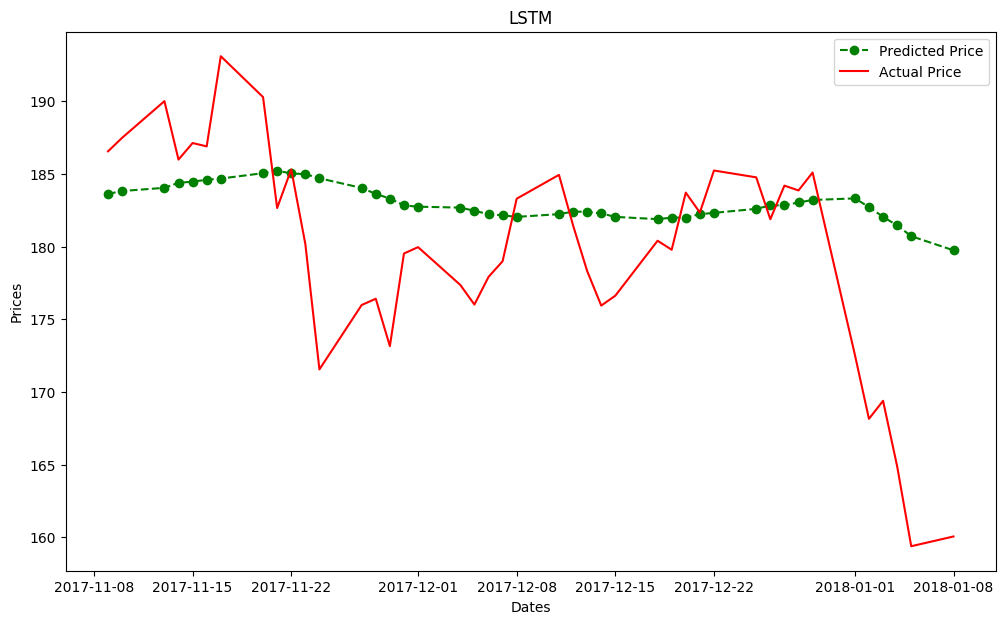

In [161]:
plt.style.use('default')
plt.figure(figsize=(12,7))

plt.plot(all_weekdays[1429:1472],testPredict[:,0], color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(all_weekdays[1429:1472],testY[0], color='red', label='Actual Price')
plt.title('LSTM')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend()

In [0]:

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))



In [162]:
error2 = smape_kun(testY[0], testPredict[:,0])
print('Symmetric mean absolute percentage error: %.3f' % error2)
error = mean_squared_error(testY[0], testPredict[:,0])
print('Testing Mean Squared Error: %.3f' % error)

Symmetric mean absolute percentage error: 3.083
Testing Mean Squared Error: 56.760
